In [65]:
import re
import os
import fnmatch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import matplotlib.pyplot as plt
from scipy import signal, stats
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sns.set()
sns.set_style('ticks')
warnings.filterwarnings('ignore')

In [122]:
def get_kde_vals(arr, xvals=None):
    
    x = arr[~np.isnan(arr)]
    kde = stats.gaussian_kde(x, bw_method='scott')
    
    if xvals is None:
        xvals = np.linspace(np.min(x)-1, np.max(x)+1, num=150)
    yvals = kde.evaluate(xvals)
    
    return xvals, yvals

# get the angle names to analyze (use _BC instead of _abduct for now)
def get_angle_names(angles, angle_types, only_t1):
    angle_names = np.array([])
    for ang in angle_types:
        if only_t1:
            angle_names = np.append(angle_names, [s for s in list(angles.columns) if '1' in s and ang in s])
        else:
            angle_names = np.append(angle_names, [s for s in list(angles.columns) if ang in s])
    # angle_names = angle_names + ['fictrac_speed', 'fictrac_rot']
    return angle_names

# adjust _rot angles so there are no discontinuities
def adjust_rot_angles(angles, angle_names):
    rot_angs = [r for r in angle_names if '_rot' in r]
    for ang in rot_angs:
        r = np.array(angles[ang])
        r[r > 50] = r[r > 50] - 360
        angles[ang] = r
    return angles

# assign a unique bout number to each bout (previously had duplicates due
# to running experiments on different days)
def adjust_bout_numbers(angles, pose3d, cumulative_bouts):
    
    bout_numbers = np.unique(angles.behavior_bout)
    bout_numbers_new = np.arange(cumulative_bouts, len(bout_numbers) + 1, 1)
    cumulative_bouts = cumulative_bouts + len(bout_numbers)
    
    for j in range(len(bout_numbers)):
        
        angles['behavior_bout'].replace({bout_numbers[j]:bout_numbers_new[j]}, inplace=True)
        pose3d['behavior_bout'].replace({bout_numbers[j]:bout_numbers_new[j]}, inplace=True)
    
    return angles, pose3d, cumulative_bouts

# returns dictionary that maps bout number to fly id
def get_fly_id(angles, bout_numbers):
    fly_id = dict()
    for j in range(len(bout_numbers)):
        bout_df = angles[angles.behavior_bout == bout_numbers[j]]
        fly_id[bout_numbers[j]] = bout_df.iloc[0].flyid
    return fly_id

def norm(X):
    X_norm = X.reshape(X.shape[0], -1)
    X_norm = X - np.mean(X, axis = 0)
    X_norm = X_norm / np.std(X, axis = 0)
    X_norm = X_norm.reshape(X.shape)
    return X_norm

def get_fly_id(angles, bout_numbers):
    fly_id = dict()
    for j in range(len(bout_numbers)):
        bout_df = angles[angles.behavior_bout == bout_numbers[j]]
        fly_id[bout_numbers[j]] = bout_df.iloc[0].flyid
    return fly_id

# get labels according to feature chosen (filename, bout, fly, behavior, etc)
def get_label_dict(labels):
    
    labels_ids = np.zeros(labels.shape, dtype='int32')
    labels_ids[:] = -1 # default for unlabeled data
    
    bad = pd.isnull(labels) | (labels == 'nan')
    labels_types = np.unique(labels[~bad])
    label_dict = dict(zip(labels_types, range(len(labels_types))))
    
    for label, num in label_dict.items():
        labels_ids[label == labels] = num
        
    return label_dict, labels_types, labels_ids

# time based features
def time_features(data, angles, filenames, label_type, nperseg, noverlap, normalize, only_t1):
    
    X_list = []
    labels_list = [] # remember to append to stft labels
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types, only_t1 = only_t1)
    
    for filename in filenames:
        sub_ixs = data['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = np.array(angles.loc[sub_ixs, angle_names])
        labels_sub = np.array(data.loc[sub_ixs, label_type])
    
        for i in range(0, X_sub.shape[0], noverlap):
            if X_sub.shape[0] > i+nperseg:
                X_list.append(X_sub[i:i+nperseg].T)
                labels_list.append(labels_sub[i+nperseg//2])
    
    X_times = np.array(X_list)
    labels_times = np.array(labels_list)
    
    return X_times, labels_times

# stft based features
def stft_features(data, angles, filenames, label_type, fps, nperseg, noverlap, normalize, only_t1):

    X_list = []
    labels_list = []
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types, only_t1 = only_t1)
    
    for filename in filenames:
        sub_ixs = data['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = angles.loc[sub_ixs, angle_names]
    
        freqs, times, Z = signal.stft(X_sub, fs=fps, nperseg=nperseg, noverlap=noverlap,
                                      axis=0, padded=False, boundary=None)
        Zs = np.log(np.abs(Z.swapaxes(0, 2)))
    
        labels_sub = np.array(data.loc[sub_ixs, label_type])
        labels_sub_down = labels_sub[::noverlap]
        Zs = Zs[:len(labels_sub_down)]
    
        # good = ~pd.isnull(labels_sub_down)
        good = np.arange(len(Zs))
    
        X_list.append(Zs[good])
        labels_list.append(labels_sub_down[good])
    
    X_stft = np.vstack(X_list)
    labels_stft = np.hstack(labels_list)
    
    if normalize:
        X_times = norm(X_stft)
    
    return X_stft, labels_stft

In [ ]:
# time based features
def time_features(data, angles, filenames, label_type, nperseg, noverlap, normalize, only_t1):
    
    X_list = []
    labels_list = [] 
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types, only_t1 = only_t1)
    
    for filename in filenames:
        sub_ixs = angles['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = np.array(angles.loc[sub_ixs, angle_names])
        labels_sub = np.array(angles.loc[sub_ixs, label_type])
    
        unique_labels = np.unique(labels_sub)
        if len(unique_labels) > 1:
            for j in range(len(unique_labels)):
                labels_sub_u = labels_sub[labels_sub == unique_labels[j]]
                X_sub_u = X_sub[labels_sub == unique_labels[j]]
                for i in range(0, X_sub_u.shape[0], noverlap):
                    if X_sub_u.shape[0] > i+nperseg:
                        X_list.append(X_sub_u[i:i+nperseg].T)
                        labels_list.append(labels_sub_u[i+nperseg//2])
        else: 
            for i in range(0, X_sub.shape[0], noverlap):
                if X_sub.shape[0] > i+nperseg:
                    X_list.append(X_sub[i:i+nperseg].T)
                    labels_list.append(labels_sub[i+nperseg//2])
    
    X_times = np.array(X_list)
    labels_times = np.array(labels_list)
    
    if normalize:
        X_times = norm(X_times)
    
    return X_times, labels_times

# stft based features
def stft_features(data, angles, filenames, label_type, fps, nperseg, noverlap, normalize, only_t1):

    X_list = []
    labels_list = []
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types, only_t1 = only_t1)

    for filename in filenames:
        sub_ixs = angles['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = angles.loc[sub_ixs, angle_names]
    
        freqs, times, Z = signal.stft(X_sub, fs=fps, nperseg=nperseg, noverlap=noverlap,
                                      axis=0, padded=False, boundary=None)
        Zs = np.log(np.abs(Z.swapaxes(0, 2)))
    
        labels_sub = np.array(angles.loc[sub_ixs, label_type])
        unique_labels = np.unique(labels_sub)
        if len(unique_labels) > 1:
            for j in range(len(unique_labels)):
        
                X_sub_u = X_sub[labels_sub == unique_labels[j]]
                freqs, times, Z = signal.stft(X_sub_u, fs=fps, nperseg=nperseg, noverlap=noverlap,
                                      axis=0, padded=False, boundary=None)
                Zs = np.log(np.abs(Z.swapaxes(0, 2)))
                
                labels_sub_u = labels_sub[labels_sub == unique_labels[j]]
                labels_sub_down = labels_sub_u[::noverlap]
                Zs = Zs[:len(labels_sub_down)]
            
                # good = ~pd.isnull(labels_sub_down)
                good = np.arange(len(Zs))
            
                X_list.append(Zs[good])
                labels_list.append(labels_sub_down[good])
        else:                  
            labels_sub_down = labels_sub[::noverlap]
            Zs = Zs[:len(labels_sub_down)]
        
            # good = ~pd.isnull(labels_sub_down)
            good = np.arange(len(Zs))
        
            X_list.append(Zs[good])
            labels_list.append(labels_sub_down[good])
    
    X_stft = np.vstack(X_list)
    labels_stft = np.hstack(labels_list)
    
    if normalize:
        X_stft = norm(X_stft)
    
    return X_stft, labels_stft

In [75]:
prefix = r'/media/turritopsis/katie/behavior-classifier'
angles_path = os.path.join(prefix, 'angles_fictrac_grooming_features.csv')
data_path = os.path.join(prefix, 'pose_3d_fictrac_grooming_features.csv')
features_path = os.path.join(prefix, 'T1_grooming_quality_check_revised.csv')
# behaviors = os.path.join(prefix, 'behavior_labels_training.csv')

data = pd.read_csv(data_path)
angles = pd.read_csv(angles_path)
features = pd.read_csv(features_path, index_col = False)
angles, data, bouts = adjust_bout_numbers(angles, data, 1)

fps = 300.0 # know this for this dataset
only_t1 = True
normalize = False
nperseg = 16
noverlap = int(nperseg // 2)
filenames = np.unique(angles.loc[:, 'filename'])
fly_dict = get_fly_id(angles, np.unique(angles.behavior_bout))

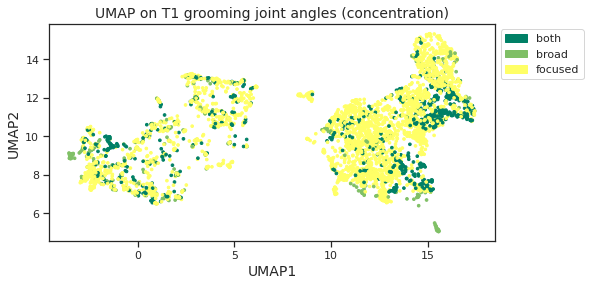

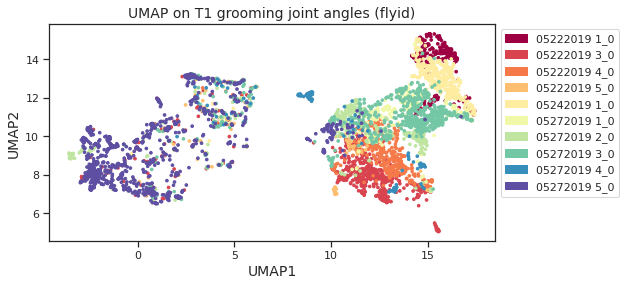

In [126]:
# UMAP: color by feature
only_t1 = True
normalize = False
nperseg = 12
noverlap = int(nperseg // 2)
label_types = ['height', 'concentration', 'motion_bias', 'synchronicity', 'side_bias']
label_types = ['height', 'flyid']

# cmap = plt.get_cmap('tab10')
cmap = plt.get_cmap('summer')
cmaps = ['summer', 'Spectral']

for j in range(len(label_types)):
    
    cmap = plt.get_cmap(cmaps[j])

    # individual inputs for time and stft features
    X_stft, labels_stft = stft_features(data, angles, filenames, label_types[j], fps, nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    X_times, labels_times = time_features(data, angles, filenames, label_types[j], nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    
    # both time and stft features, but could use only the stft or time data/labels
    X = np.dstack([X_stft[:X_times.shape[0]], X_times])
    X_in = X.reshape(X.shape[0], -1)
    labels = labels_stft[:X_times.shape[0]]
    # X_in = X_times
    # X_in = X_in.reshape(X_in.shape[0], -1)
    # labels = labels_times
    label_dict, labels_types, labels_ids = get_label_dict(labels)
    
    # umap
    xmap = umap.UMAP(init='spectral', min_dist=0.2, n_components=2, random_state = 1)
    X_map = xmap.fit_transform(X_in)
    
    fig = plt.figure(figsize = (8,4))
    good = labels_ids != -1
    # plt.scatter(X_map[good, 0], X_map[good, 1], c=cmap(labels_ids[good]), s=7)
    plt.scatter(X_map[good, 0], X_map[good, 1], c=labels_ids[good], cmap = cmap, s=7)
    plt.title('UMAP on T1 grooming joint angles (' + label_types[j] + ')', fontsize = 14)
    plt.xlabel('UMAP1', fontsize = 14)
    plt.ylabel('UMAP2', fontsize = 14)
    n = len(labels_types)
    if label_types[j] == 'behavior_bout':
        # patches = [Patch(color=cmap(i % 20), label = str(x) + ' (' + fly_dict[i+1] + ')') for i, x in enumerate(labels_types)]
        patches = [Patch(color=cmap(i/(n-0.9999)), label = str(x) + ' (' + fly_dict[i+1] + ')') for i, x in enumerate(labels_types)]
    else: 
        # patches = [Patch(color=cmap(i % 20), label = x) for i, x in enumerate(labels_types)]
        patches = [Patch(color=cmap(i/(n-0.9999)), label = x) for i, x in enumerate(labels_types)]
    plt.legend(handles=patches, bbox_to_anchor = (1, 1))
    plt.show()

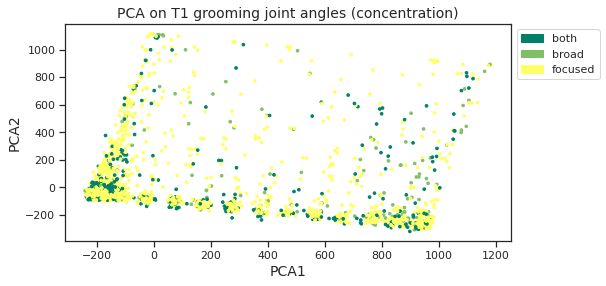

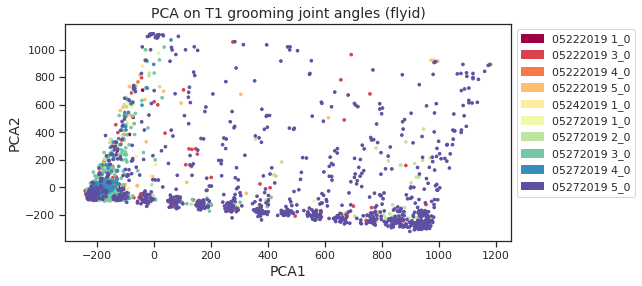

In [127]:
# PCA: color by feature
only_t1 = True
normalize = False
nperseg = 12
noverlap = int(nperseg // 2)
label_types = ['height', 'concentration', 'motion_bias', 'synchronicity', 'side_bias']
label_types = ['height', 'flyid']

# cmap = plt.get_cmap('tab10')
cmap = plt.get_cmap('summer')
cmaps = ['summer', 'Spectral']

for j in range(len(label_types)):
    
    cmap = plt.get_cmap(cmaps[j])

    # individual inputs for time and stft features
    X_stft, labels_stft = stft_features(data, angles, filenames, label_types[j], fps, nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    X_times, labels_times = time_features(data, angles, filenames, label_types[j], nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    
    # both time and stft features, but could use only the stft or time data/labels
    X = np.dstack([X_stft[:X_times.shape[0]], X_times])
    X_in = X.reshape(X.shape[0], -1)
    labels = labels_stft[:X_times.shape[0]]
    # X_in = X_times
    # X_in = X_in.reshape(X_in.shape[0], -1)
    # labels = labels_times
    label_dict, labels_types, labels_ids = get_label_dict(labels)
    
    # pca
    pca = PCA(n_components=2)
    X_map = pca.fit_transform(X_in)
    explained_variance = pca.explained_variance_ratio_
    singular_values = pca.singular_values_
    
    fig = plt.figure(figsize = (8,4))
    good = labels_ids != -1
    # plt.scatter(X_map[good, 0], X_map[good, 1], c=cmap(labels_ids[good]), s=7)
    plt.scatter(X_map[good, 0], X_map[good, 1], c=labels_ids[good], cmap = cmap, s=7)
    plt.title('PCA on T1 grooming joint angles (' + label_types[j] + ')', fontsize = 14)
    plt.xlabel('PCA1', fontsize = 14)
    plt.ylabel('PCA2', fontsize = 14)
    n = len(labels_types)
    if label_types[j] == 'behavior_bout':
        # patches = [Patch(color=cmap(i % 20), label = str(x) + ' (' + fly_dict[i+1] + ')') for i, x in enumerate(labels_types)]
        patches = [Patch(color=cmap(i/(n-0.9999)), label = str(x) + ' (' + fly_dict[i+1] + ')') for i, x in enumerate(labels_types)]
    else: 
        # patches = [Patch(color=cmap(i % 20), label = x) for i, x in enumerate(labels_types)]
        patches = [Patch(color=cmap(i/(n-0.9999)), label = x) for i, x in enumerate(labels_types)]
    plt.legend(handles=patches, bbox_to_anchor = (1, 1))
    plt.show()

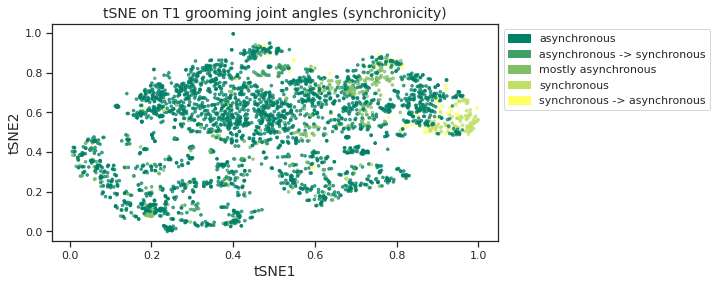

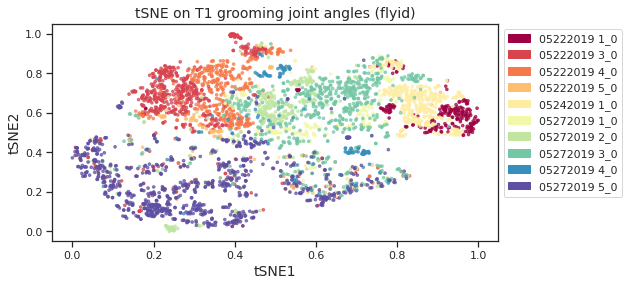

In [132]:
# PCA: color by feature
only_t1 = True
normalize = False
nperseg = 12
noverlap = int(nperseg // 2)
label_types = ['height', 'concentration', 'motion_bias', 'synchronicity', 'side_bias']
label_types = ['height', 'flyid']

# cmap = plt.get_cmap('tab10')
cmap = plt.get_cmap('Spectral')
cmaps = ['summer', 'Spectral']

for j in range(len(label_types)):
    
    cmap = plt.get_cmap(cmaps[j])

    # individual inputs for time and stft features
    X_stft, labels_stft = stft_features(data, angles, filenames, label_types[j], fps, nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    X_times, labels_times = time_features(data, angles, filenames, label_types[j], nperseg, noverlap, normalize = normalize, only_t1 = only_t1)
    
    # both time and stft features, but could use only the stft or time data/labels
    X = np.dstack([X_stft[:X_times.shape[0]], X_times])
    X_in = X.reshape(X.shape[0], -1)
    labels = labels_stft[:X_times.shape[0]]
    # X_in = X_stft
    # X_in = X_in.reshape(X_in.shape[0], -1)
    # labels = labels_stft
    label_dict, labels_types, labels_ids = get_label_dict(labels)
    
    # tsne
    # tsne = TSNE(n_components=2, init='pca', random_state = 1) # reproducible
    tsne = TSNE(n_components=2, random_state = 1) # stochastic
    X_map = tsne.fit_transform(X_in)
    x_min, x_max = np.min(X_map, 0), np.max(X_map, 0)
    X_map = (X_map - x_min) / (x_max - x_min)
    
    fig = plt.figure(figsize = (8,4))
    good = labels_ids != -1
    # plt.scatter(X_map[good, 0], X_map[good, 1], c=cmap(labels_ids[good]), s=7)
    plt.scatter(X_map[good, 0], X_map[good, 1], c=labels_ids[good], cmap = cmap, s=7, alpha = 0.7)
    plt.title('tSNE on T1 grooming joint angles (' + label_types[j] + ')', fontsize = 14)
    plt.xlabel('tSNE1', fontsize = 14)
    plt.ylabel('tSNE2', fontsize = 14)
    n = len(labels_types)
    if label_types[j] == 'behavior_bout':
        # patches = [Patch(color=cmap(i % 20), label = str(x) + ' (' + fly_dict[i+1] + ')') for i, x in enumerate(labels_types)]
        patches = [Patch(color=cmap(i/(n-0.9999)), label = str(x) + ' (' + fly_dict[i+1] + ')') for i, x in enumerate(labels_types)]
    else: 
        # patches = [Patch(color=cmap(i % 20), label = x) for i, x in enumerate(labels_types)]
        patches = [Patch(color=cmap(i/(n-0.9999)), label = x) for i, x in enumerate(labels_types)]
    plt.legend(handles=patches, bbox_to_anchor = (1, 1))
    plt.show()